$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\newcommand{\norm}[1]{\|#1\|_2}
$$

In [1]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D
if "bmh" in plt.style.available: plt.style.use("bmh");
    
# matplotlib objects
from matplotlib import mlab;
from matplotlib import gridspec;

# scientific
import numpy as np;
import scipy as scp;
import scipy.stats;

# scikit-learn
import sklearn;
from sklearn.kernel_ridge import KernelRidge;

# python
import random;

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll': False
});

# EECS 545:  Machine Learning
## Lecture 10:  Bayesian Linear Regression & Gaussian Processes
* Instructor:  **Jacob Abernethy**
* Date:  February 15, 2015

*Lecture Exposition Credit: Ben & Valli*

## References

This lecture draws upon the following resources:

- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://www.springer.com/us/book/9780387310732).  2006.
- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[CS229]** Ng, Andrew.  [CS 229:  Machine Learning](http://cs229.stanford.edu/).  Autumn 2015.
    - [Gaussian Processes](http://cs229.stanford.edu/section/cs229-gaussian_processes.pdf)
    - [More on Gaussians](http://cs229.stanford.edu/section/more_on_gaussians.pdf)

## Outline

- Finish SVM and Dual Optimization
- More on Multivariate Gaussians
    - Partitioned Marginals and Conditionals
    - Bayes' Theorem for Gaussians
- Bayesian Linear Regression
- Gaussian Process Regression
    - Gaussian Processes

### Maximum Margin Classifier

**(Functional) Margin:** The distance from a separating hyperplane to the closest datapoint of any class.

**Max. Margin Classifiers:** separate data by looking for the hyperplane that maximizes the margin.
- "best" linear classifier in terms of generalization
- misclassification unlikely with a wide margin between classes.

### Maximum Margin Classifier:  Example Code

In [3]:
# ADAPTED FROM SCIKIT-LEARN EXAMPLE
# (http://scikit-learn.org/stable/modules/svm.html)

def max_margin_classifier(ax, X, Y):
    clf = sklearn.svm.SVC(kernel='linear')
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    m = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = m * xx - (clf.intercept_[0]) / w[1]

    # plot the parallel lines to the separating hyperplane that pass through the
    # support vectors
    t = clf.support_vectors_[0]
    yy_down = m * xx + (t[1] - m * t[0])
    t = clf.support_vectors_[-1]
    yy_up = m * xx + (t[1] - m * t[0])

    ax.plot(xx, yy, 'k-')
    ax.plot(xx, yy_down, 'k--')
    ax.plot(xx, yy_up, 'k--')

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=120, facecolors='none', edgecolors='k', linewidth=3);
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, s=40)

    ax.axis('tight')
    
    return w

def plot_svc():
    # Create 30 random points
    np.random.seed()
    X = np.r_[np.random.randn(30, 2) - [3, 3], np.random.randn(30, 2) + [3, 3]]
    Y = [0] * 30 + [1] * 30

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    w = max_margin_classifier(ax, X, Y)
    plt.quiver(0, 0, 2 * w[0], 2 * w[0]/w[1],
               angles='xy', scale_units='xy', scale=2)
    
    plt.title("Support Vector Classifier");

### Maximum Margin Classifier:  Example

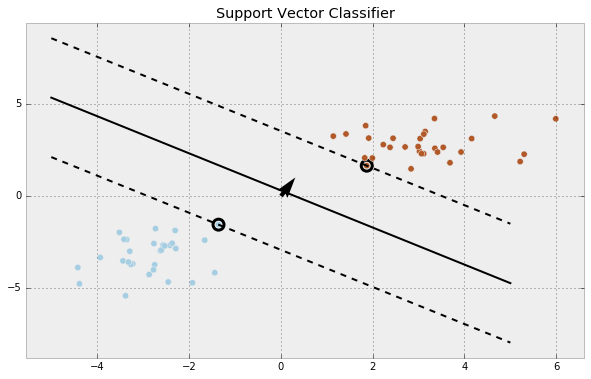

In [4]:
# Note: The separating hyperplane is the line between the two dotted lines. 
# The two dotted lines specify the margin and points on the margin are circled.
plot_svc();

### Margin Equation

The margin $\rho$ of a hyperplane is given by
$$
\rho
= \rho(w, b) 
= \min_{i = 1, ..., n} \frac{|\mathbf{w}^T\mathbf{x}_i + b|}{||\mathbf{w}||}
$$
- where $\mathbf{x}_i$ is the $i^\text{th}$ datapoint from the training set.

### Finding the Max-Margin Hyperplane

As with other linear classifiers, let the classifier be given by
$$
f(\mathbf{x})
= \text{sign}(\mathbf{w}^T\mathbf{x} + b)
$$

The maximum margin separating hyperplane is then given by the following optimization problem

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{maximize}}
& & \rho(\mathbf{w}, b)\\
& \text{subject to}
& & y_i(\mathbf{w}^T\mathbf{x}_i + b) > 0
\end{aligned}
\end{equation*}
$$

### Canonical Form

- Let $m := \min_{i = 1, ..., n} |\mathbf{w_1}^T\mathbf{x}_i + b_1|$ (Simply renaming $\mathbf{w}$ as $\mathbf{w}_1$ and $b$ as $b_1$.
- Then, scaling $\mathbf{w}_1$ and $b_1$ by $\frac{1}{m}$ keeps the hyperplane unaffected.
- $\mathbf{w_2} = \frac{\mathbf{w_1}}{m}$ and $b_2 = \frac{b_1}{m}$ express the hyperplane in canonical form.

### Restatement of Optimization Problem

Using the canonical form, we can rewrite the optimization problem as $$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{maximize}\min_i} 
& & \frac{|\mathbf{w}^T\mathbf{x}_i + b|}{||\mathbf{w}||}\\
& \text{subject to}
& & y_i(\mathbf{w}^T\mathbf{x}_i + b) \geq 1, \forall i\\
& & & y_i(\mathbf{w}^T\mathbf{x}_i + b) = 1 \text{ for some } i
\end{aligned}
\end{equation*}$$

Simplifying further (**Exercise:** try to verify this!), we have $$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{minimize}} 
& & \frac{1}{2}{||\mathbf{w}||}^2\\
& \text{subject to}
& & y_i(\mathbf{w}^T\mathbf{x}_i + b) \geq 1, \forall i\\
\end{aligned}
\end{equation*}$$

### Linear Separability

- Two classes of data are said to be **linearly separable** if there exists a hyperplane that separates them without any errors.
- So far, we have looked at primarily linearly separable data where a single hyperplane will do for classification.
- We can extend on this notion to a multiclass scenario by considering data to be linearly separable if there exists a set of hyperplanes that can classify each class of examples from the rest (again without errors).

### Ideas for dealing with data that aren't linearly separable

- Use "slack" variables that allow for misclassification and penalize misclassification.
- Extend linear classifiers with kernels.

### Optimal Soft-Margin Hyperplane (OSMH)

Learn a linear classifier which solves 

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{minimize}} 
& & \frac{1}{2} {||\mathbf{w}||}^2 + \frac{C}{n} \sum_{i = 1}^n \xi_i\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) \geq 1 - \xi_i,\quad i = 1, ..., n\\
& & & \xi_i \geq 0,\quad i = 1, ..., n
\end{aligned}
\end{equation*}
$$

where we now have a new term that penalizes errors and accounts for the influence of outliers through a constant $C \geq 0$ (0 would lead us back to the hard margin case) and $\mathbf{\xi} = [\xi_1, ..., \xi_n]$ are the slack variables.

### OSMH:  Motivation

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{maximize}} 
& & \frac{1}{2} {||\mathbf{w}||}^2 + \frac{C}{n} \sum_{i = 1}^n \xi_i\\
& \text{subject to}
& & y_i(\mathbf{w}^Tx_i + b) \geq 1 - \xi_i, \quad i = 1, ..., n\\
& & & \xi_i \geq 0, \quad i = 1, ..., n
\end{aligned}
\end{equation*}
$$

* The **objective function** ensures margin is large *and* the margin violations are small
* The **first set of constraints** ensures classifier is doing well
    * similar to the prev. max-margin constraint, except we now allow for slack
* The second set of constraints ensure slack vars non-neg.
    * keeps the optimization problem from *"diverging"*

### The OSMH optimization problem

The OSMH optimization is a convex optimization problem
- objective function is quadratic
- inequality constraints are affine (and hence convex).

Note that strong duality holds.

### Review:  Lagrangian 

Consider a ** constrained optimization problem ** 

$$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{x} \in \mathbb{R}^d}{\text{minimize}} 
& & f(\mathbf{x})\\
& \text{subject to}
& & g_i(\mathbf{x}) \leq 0, i = 1, ..., m\\
& & & h_j(x) = 0, j = 1, ..., n
\end{aligned}
\end{equation*}$$

The Lagrangian is then given by $$L(\mathbf{x}, \alpha, \beta) = f(\mathbf{x}) + \sum \limits_{i = 1}^m \alpha_i g_i(\mathbf{x}) + \sum \limits_{j = 1}^n \beta_j h_j(\mathbf{x})$$ 

Here, $\alpha$ and $\beta$ are the ** Lagrange Multipliers / Dual Variables ** associated with the inequality constraints and equality constraints repsectively.

### Review:  Lagrangian Dual 

- The Lagrangian Dual objective is given by $L_D (\alpha, \beta) = \min_{\mathbf{x}} L(\mathbf{x}, \alpha, \beta)$

- The Dual Optimization problem is given by $\max \limits_{\alpha, \beta: \alpha_i \geq 0} L_D(\alpha, \beta)$

- Note, $L_D$ is concave, because it is a piece-wise minimimum of affine functions.

- The Lagrange Primal objective is given by
$L_P(\mathbf{x}) := \max \limits_{\alpha, \beta: \alpha_i \geq 0} L(\mathbf{x}, \alpha, \beta) = \begin{cases} f(x) & \text{ if } x \text{ is feasible}\\ \infty & \text{ otherwise}\end{cases}$

- Notice that the Lagrange Primal Optiminization problem,  $\min_{\mathbf{x}} L_P(\mathbf{x})$, is identical to the original optimization problem!

### Review:  Strong and Weak Duality 

$$p^* = \min \limits_{\mathbf{x}} L_p(\mathbf{x}) = \min_{\mathbf{x}} \max \limits_{\alpha, \beta: \alpha_i \geq 0} L(\mathbf{x}, \alpha, \beta)$$

$$d^* = \max \limits_{\alpha, \beta: \alpha_i \geq 0} L_D(\alpha, \beta) = \max \limits_{\alpha, \beta: \alpha_i \geq 0}\min_{\mathbf{x}} L(\mathbf{x}, \alpha, \beta)$$

- Weak duality: $d^* \leq p^*$
- Strong duality: $p^* = d^*$

- The original problem is said to be ** convex (cvx) ** is $f, g_1, ..., g_m$ are convex and $h_1, ..., h_n$ are affine. 

- If the original problem is cvx. and a *constraint qualification* holds, then $p^* = d^*$. 

- Example of constraint qualification: All $g_i$ are affine and Strict Feasibility, $\exists \mathbf{x} \text{ s.t. } \forall j, h_j(\mathbf{x}) = 0 \wedge \forall i, g_i(\mathbf{x}) < 0$

### Review:  Karesh-Kuhn-Tucker Conditions

**Thm.** If $p^* = d^*$, $\mathbf{x}^*$ is primal optimal and $(\alpha^*, \beta^*)$ are dual optimal, then the KKT conditions hold: 

1. $\nabla f(\mathbf{x}^* + \sum_i \alpha_i^* \nabla g_i(\mathbf{x}^*) + \sum_j \beta_j^* \nabla h_j (x^*) = 0$
2. $\forall\, i$, $g_i(\mathbf{x}^*) \leq 0\quad\quad$  (by feasibility of $\mathbf{x}^*$)
3. $\forall\, j$, $h_j(\mathbf{x}^*) = 0\quad\quad$  (by feasibility of $\mathbf{x}^*$)
4. $\forall\, i$, $\alpha_i^* \geq 0\quad\quad $ (by defn. of the dual problem)
5. $\forall\, i$, $\alpha_i^* g_i(\mathbf{x}^*) = 0\quad\quad$  (complimentary slackness)

### Review:  KKT (Proof of 1 and 5)

$\begin{align} 
f(x^*) & = L_D(\alpha^*, \beta^*) \text{ [by Strong duality] }\\
& = \min \limits_{\mathbf{x}} (f(\mathbf{x}) + \sum_i \alpha_i g_i(\mathbf{x}) + \sum_j \beta_j h_j(\mathbf{x})\\
& \leq f(\mathbf{x}^*) + \sum_i \lambda_i^* g_i(\mathbf{x^*}) + \sum_j \beta_j h_j(\mathbf{x}^*)\\
& \leq f(x^*) \text{ [by 2 - 4] }
\end{align}$

Noting the inequalities are really then equalities:
- The equality of the last two lines, we get that $\forall i, \alpha_i^* g_i(\mathbf{x}^*) = 0$.

- The equality of the second and third lines imply $\mathbf{x}^*$ is a minimizer of $L(\mathbf{x}, \alpha^*, \beta^*) \text { w.r.t. } \mathbf{x}$. Therefore, $\nabla_x L(\mathbf{x}^*, \alpha^*, \beta^*) = 0$.

### OSMH:  Lagrangian 

The Lagrangian is given by 
\begin{align}
& L(\mathbf{w}, b, \mathbf{\xi}, \alpha, \beta) = \frac{1}{2} {||\mathbf{w}||}^2 + \frac{C}{n}\sum_i \xi_i \\
& \quad \quad - \sum \limits_{i = 1}^n \alpha_i (y_i (\mathbf{w}^T \mathbf{x}_i + b) - 1 + \xi_i) - \sum \limits_{i = 1}^n \beta_i \xi_i
\end{align}

### OSMH: Dual Problem 

- So, the Lagrangian Dual is given by the following unconstrained optimization problem
$$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{minimize}} 
& & L(\mathbf{w}, b, \mathbf{\xi}, \alpha, \beta)
\end{aligned}
\end{equation*}$$

- Thus, the dual problem given by the following optimization 

$$\begin{equation*}
\begin{aligned}
& \underset{\mathbf{w}, b, \mathbf{\xi}}{\text{maximize}} 
& & L_D(\alpha, \beta)\\
& \text{subject to}
& & \alpha \geq 0, \beta \geq 0
\end{aligned} 
\end{equation*}$$

### OSMH:  The Unconstrained Minimization

For a fixed $\alpha$, $\beta$, we can minimize the primal variables as follows:

- $\frac{\partial L}{\partial \mathbf{w}} = \mathbf{w} - \sum_{i} \alpha_i y_i \mathbf{x}_i = 0, \forall i$
- $\frac{\partial L}{\partial b} = \sum_i \alpha_i y_i = 0, \forall i$
- $\frac{\partial L}{\partial \xi_i} = \frac{C}{n} - \alpha_i - \beta_i = 0, \forall i$

${||w||}^2 = {||\sum_i \alpha_i y_i \mathbf{x}_i||}^2 = \sum \limits_{i, j = 1}^n \alpha_i \alpha_j y_i y_j \mathbf{x}_i^T \mathbf{x}_j$

Thus, $\boxed{L_D(\alpha, \beta) = \frac{-1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_j\mathbf{x}_i^T \mathbf{x}_j + \sum_i \alpha_i}$

### OSMH: Dual Problem Revisited
#### (Note the inner product!)

$$\begin{equation*}
\begin{aligned}
& \underset{\alpha, \beta}{\text{maximize}} 
& & - \frac{1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_j \langle\mathbf{x}_i, \mathbf{x}_j \rangle + \sum_i \alpha_i\\
& \text{subject to}
& & \sum_i \alpha_i y_i = 0\\
& & & \forall i, \alpha_i + \beta_i = \frac{C}{n}\\
& & & \forall i, \alpha_i \geq 0,\beta_i \geq 0
\end{aligned} 
\end{equation*}$$


### OSMH: Eliminating Constraints

By eliminating $\beta$, we can write the dual optimization as the following QP

$$\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{maximize}} 
& & \frac{-1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_j \langle \mathbf{x}_i, \mathbf{x}_j \rangle + \sum_i \alpha_i\\
& \text{subject to}
& & \sum_i \alpha_i y_i = 0\\
& & & \forall i, 0 \leq \alpha_i \leq \frac{C}{n}
\end{aligned} 
\end{equation*}$$

### OSMH:  Observations 

- Let $\mathbf{w}^*, b^*$ and $\mathbf{\xi}^*$ be the primal optimal solutions and $\alpha^*$ and $\beta^*$ be the dual optimal solutions.

- From the KKT conditions, we have $\mathbf{w}^* = \sum \limits_{i = 1}^n \alpha_i^* y_i \mathbf{x}_i$. So, the optimal normal vector to the hyperplane is a linear combination of datapoints!

### OSMH:  Observations
- From the complimentary slackness KKT condition, $\alpha_i^* (1 - \xi_i^* - y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*)) = 0$. 

- If $\mathbf{x}_i$ satisfies $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) = 1 - \xi_i^*$, we call $\mathbf{x}_i$ a support vector. In other words, if $\mathbf{x}_i$ is not a support vector, $\alpha_i^* = 0$. 

- The above means that $\mathbf{w}^*$ depends only on the support vectors!

### OSMH:  Geometric Interpretation

- If $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) > 1$, then $\xi_i^* = 0$, $\mathbf{x}_i$ is outside the margin and is not a SV.
- If $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) = 1$, then $\xi_i^* = 0$, $\mathbf{x}_i$ is on the margin and is a SV.
- If $0 \leq y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) < 1$, then $\xi_i^* > 0$, $\mathbf{x}_i$ is within the margin and is a SV.
- If $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) < 0$, then $\xi_i^* > 0$, $\mathbf{x}_i$ is misclassified and is a SV.

<img src="images/SVM.jpg">

### OSMH:  Optimal offset

- If $\alpha_i^* < \frac{C}{n}$, then $\xi_i^* = 0$ (applying KKT Complementary Slackness to the constraint $\beta_i^*\xi_i^* = 0$).

- If $\alpha_i^* < \frac{C}{n}$ then $\beta_i^* > 0$ and so $\xi_i = 0$.

- Using the above, consider any $i$ such that $0 < \alpha_i^* < \frac{C}{n}$. Then, $y_i({\mathbf{w}^*}^T\mathbf{x}_i + b^*) = 1 - \xi_i^* = 1$.

- Solving for $b^*$ using $y_i = \pm 1 \implies y_i^2 = 1$, we get $b^* = y_i - {\mathbf{w}^*}^T\mathbf{x}_i$.

### OSMH: Support Vector Machines

The dual problem and final classifier only involve the data via inner products. 
- We can apply the **kernel trick** and kernelize the OSMH problem.
- The resulting classifier is known as a *Support Vector Machine*.

Let $k$ be an inner product kernel. The SVM Classifier is given by

$$\boxed{f(\mathbf{x}) = sign(\sum \limits_{i = 1}^n \alpha_i^* y_i k(x, x_i) + b^*)}$$ 

### OSMH:  Support Vector Machines

Here, $\alpha^* = [\alpha_1^*, ..., \alpha_n^*]^T$ is the solution of 

$$\begin{equation*}
\boxed{\begin{aligned}
& \underset{\alpha}{\text{maximize}} 
& & \frac{-1}{2} \sum \limits_{i, j = 1}^n \alpha_i\alpha_jy_iy_jk(\mathbf{x}_i, \mathbf{x}_j) + \sum_i \alpha_i\\
& \text{subject to}
& & \sum_i \alpha_i y_i = 0\\
& & & \forall i, 0 \leq \alpha_i \leq \frac{C}{n}
\end{aligned}}
\end{equation*}$$

and $\boxed{b^* = y_i - \sum_{j = 1}^n \alpha_j^*y_jk(x_j, x_i)}$ for some $i$ such that $0 < \alpha_i^* < \frac{C}{n}$

In [5]:
%matplotlib inline

import numpy as np
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pylab as pl

"""
Demonstrates how a linearly nonseparable dataset in R^2 can be 
linearly separable in R^3 after a transformation via an appropriate
kernel function.

Generates a 2D non-separable dataset, and projects it to R^3 using
a polynomial kernel [x1, x2] -> [x1, x2, x1^2.0 + x2^2.0], where
it is now linearly separable in R^3.

Usage:
    $ python demo_data_transform.py
"""

def randrange(n, vmin, vmax):
    return (vmax-vmin)*np.random.rand(n) + vmin

def fn_kernel(x1, x2):
    """ Implements a polynomial kernel phi(x1,y1) = [x1, y1, x1^2 + y1^2] """
    return np.array([x1, x2, x1**2.0 + x2**2.0])

""" Generate linearly nonseparable dataset (in R^2) """
    
n = 1000

X, Y = make_circles(n_samples=n, noise=0.1, factor=0.4)

A = X[np.where(Y == 0)]
B = X[np.where(Y == 1)]

X0_orig = A[:, 0]
Y0_orig = A[:, 1]

X1_orig = B[:, 0]
Y1_orig = B[:, 1]

frac0 = len(np.where(Y == 0)[0]) / float(len(Y))
frac1 = len(np.where(Y == 1)[0]) / float(len(Y))

A = np.array([fn_kernel(x,y) for x,y in zip(np.ravel(X0_orig), np.ravel(Y0_orig))])
X0 = A[:, 0]
Y0 = A[:, 1]
Z0 = A[:, 2]

A = np.array([fn_kernel(x,y) for x,y in zip(np.ravel(X1_orig), np.ravel(Y1_orig))])
X1 = A[:, 0]
Y1 = A[:, 1]
Z1 = A[:, 2]

def plot_no_decision_boundary():    
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')

    ax.scatter(X0, Y0, Z0, c='r', marker='o')
    ax.scatter(X1, Y1, Z1, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title("Data in R^3 (separable)")

    # Project data to X/Y plane
    ax2d = fig.add_subplot(122)
    ax2d.scatter(X0, Y0, c='r', marker='o')
    ax2d.scatter(X1, Y1, c='b', marker='^')

    ax2d.set_xlabel('X Label')
    ax2d.set_ylabel('Y Label')
    ax2d.set_title("Data projected to R^2 (nonseparable)")

    plt.show()

def plot_decision_boundary():
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(121, projection='3d')

    ax.scatter(X0, Y0, Z0, c='r', marker='o')
    ax.scatter(X1, Y1, Z1, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title("Data in R^3 (separable w/ hyperplane)")

    x = np.arange(-1.25, 1.25, 0.1)
    y = np.arange(-1.25, 1.25, 0.1)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros(X.shape)
    Z[:,:] = 0.5

    ax.plot_surface(X, Y, Z, color='#FFFFFF')

    # Project data to X/Y plane
    ax2d = fig.add_subplot(122)
    ax2d.scatter(X0, Y0, c='r', marker='o')
    ax2d.scatter(X1, Y1, c='b', marker='^')

    ax2d.add_patch(pl.Circle((0,0), radius=sqrt(0.5),
                   fill=False, linestyle='solid', linewidth=4.0,
                   color='black'))
    ax2d.add_patch(pl.Circle((0,0), radius=sqrt(0.5),
                   fill=False, linestyle='dashed', linewidth=1.5,
                   color='#09F911'))
    
    ax2d.set_xlabel('X Label')
    ax2d.set_ylabel('Y Label')
    ax2d.set_title("Data projected to R^2 (hyperplane projection shown)")
    
    plt.ion()
    
    ax.view_init(azim = 210,elev = 5)
    plt.draw()

### SVM:  Example

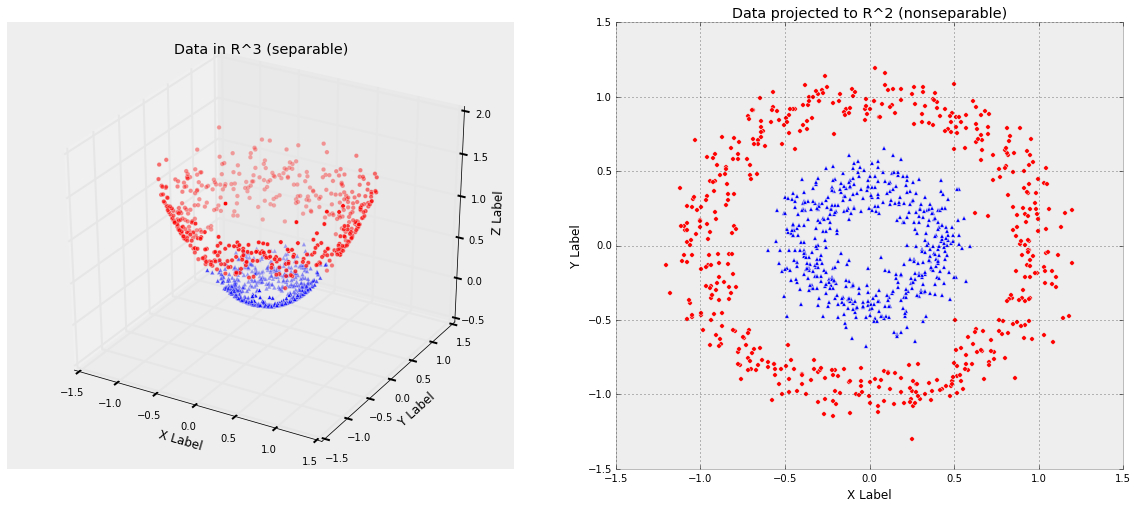

In [6]:
# Polynomial Kernel Example
plot_no_decision_boundary()

### SVM:  Decision Boundary

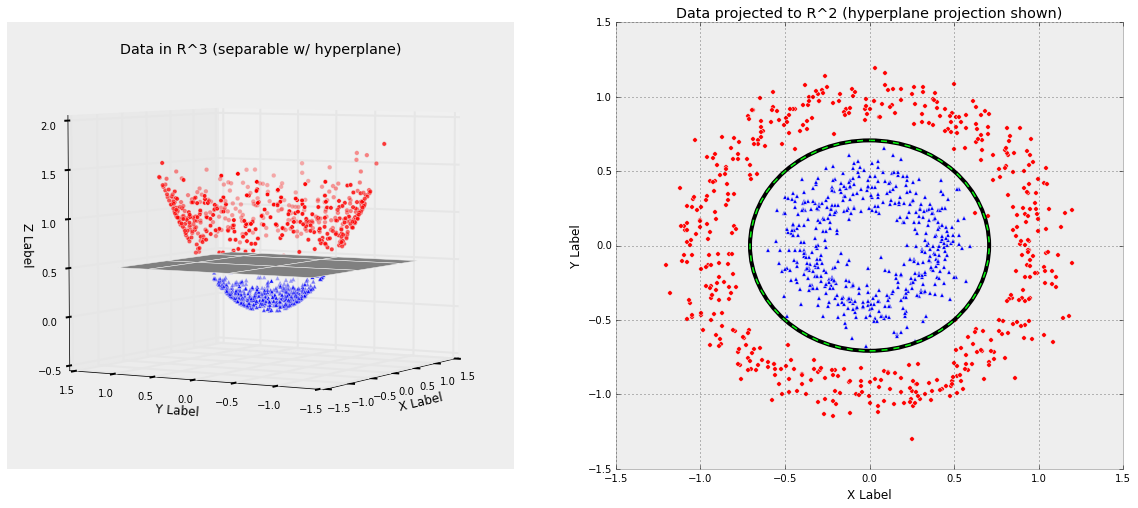

In [7]:
plot_decision_boundary()

### SVM:  Kernels

Choice of kernels
- Gaussian or polynomial kernels are used quite often
- If simple kernels are ineffective, more elaborate kernels can be used (Radial Basis Functions provide an infinite dimensional mapping!)

### SVM:  Kernels

Choice of Kernel Parameters
- Ex: Gaussian Kernel; $K(x, z) = \exp \left(- \frac{{||x - z||}^2}{2\sigma^2} \right)$. As a heuristic, the Bandwidth ($\sigma$) can be chosen to be the distance between neighboring points whose labels will likely affect the prediction of the query point.

### How to solve for the SVM dual?

- "Chunking Algorithm" 

    - Start with a random subset of the data and keep iteratively adding examples which violate the optimality conditions. 
    - Problem: QP problem scales with the number of SVs.
    - Most SVM problems were solved with such algorithms in expensive QP solver softwares prior to SMO (see below).

### Sequential Minimal Optimization 
   - Divide the Dual problem into smaller sub-problems each of which consists of 2 of the linear equality constraint Lagrange multipliers ($\alpha$'s). 
   - Find a lagrange multiplier $\alpha_1$ that violates the KKT conditions. 
   - Pick a second multiplier $\alpha_2$ and optimize the pair $(\alpha_1, \alpha_2)$ using **coordinate ascent**.
   - Repeat the previous 2 steps until convergence (the KKT conditions are satisifed within a user-defined tolerance).
   
See Platt (1998) for details.

## Break Time! 

<img src="http://media4.popsugar-assets.com/files/2014/08/08/862/n/1922507/4a4c0c4f69fa14f4_giphy-1OoaWiu.xxxlarge/i/JUST-STAHP-OK-Grumpy-Cat.gif"/>

# More on Multivariate Gaussians

> Taken from **[PRML]** §2.3, **[MLAPP]** §4.3, 4.4, and **[CS229]**

### Review:  Multivariate Gaussians

Recall the **Multivariate Normal / Gaussian** distribution with 
- mean $\mu \in \R^D$
- covariance matrix $\Sigma \in \R^{D \times D}$

$$
\mathcal{N}(x | \mu, \Sigma)
= \frac{1}{(2\pi)^{D/2}} \frac{1}{|\Sigma|^{1/2}}
\exp\left[ -\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x - \mu) \right]
$$

### Partitioned Gaussian Distributions

Partition $x \sim \mathcal{N}(\mu, \Sigma)$ as $x = [x_a, x_b]^T$, and
- Mean and covariance
$$
\mu = \begin{bmatrix} \mu_a \\ \mu_b \end{bmatrix}
\quad
\Sigma = \begin{bmatrix}
    \Sigma_{aa} & \Sigma_{ab} \\
    \Sigma_{ba} & \Sigma_{bb}
\end{bmatrix}
$$
- Precision Matrix
$$
\Lambda = \Sigma^{-1}
= \begin{bmatrix}
    \Lambda_{aa} & \Lambda_{ab} \\
    \Lambda_{ba} & \Lambda_{bb}
\end{bmatrix}
$$

### Partitioned Marginals

**Exercise:**  Marginals are obtained by taking a subset of rows and columns:

$$
\begin{align}
P(x_a)
&= \int P(x_a, x_b) \,dx_b \\
&= \mathcal{N}(x_a | \mu_a, \Sigma_{aa})
\end{align}
$$

> Marginals are Gaussian!

### Partitioned Marginals:  Example Code

In [8]:
def plot_mvn(sigmax, sigmay, mux, muy, corr):
    # dimensions
    radius = 3 * max(sigmax, sigmay);
    # create grid
    x = np.linspace(mux-radius, mux+radius, 100);
    y = np.linspace(muy-radius, muy+radius, 100);
    X, Y = np.meshgrid(x, y);
    
    # data limits
    xlim = (x.min(), x.max());
    ylim = (y.min(), y.max());
    
    # bivariate and univariate normals
    sigmaxy = corr * np.sqrt(sigmax * sigmay);
    Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mux, muy, sigmaxy);
    zx = np.sum(Z, axis=0); #mlab.normpdf(x, mux, sigmax);
    zy = np.sum(Z, axis=1); #mlab.normpdf(y, muy, sigmay);
    
    # figure
    fig = plt.figure(figsize=(8,8));
    
    # subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[5,1], height_ratios=[1,5]);
    ax_xy = fig.add_subplot(gs[1,0]);
    ax_x  = fig.add_subplot(gs[0,0], sharex=ax_xy);
    ax_y  = fig.add_subplot(gs[1,1], sharey=ax_xy);
    
    # plot
    ax_xy.imshow(Z, origin='lower', extent=xlim+ylim, aspect='auto');
    ax_x.plot(x, zx);
    ax_y.plot(zy, y);
    
    # hide labels
    ax_x.xaxis.set_visible(False);
    ax_x.yaxis.set_visible(False);
    ax_y.xaxis.set_visible(False);
    ax_y.yaxis.set_visible(False);
    
    # layout & title
    plt.tight_layout();

### Partitioned Marginals:  Bivariate Example

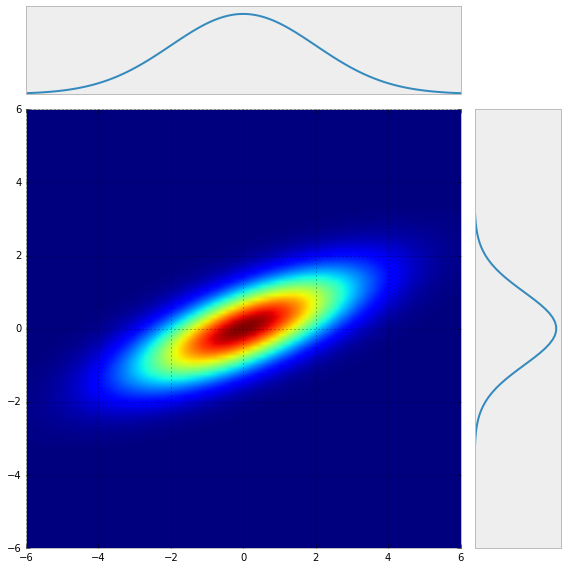

In [9]:
# sigmax, sigmay, mux, muy, corr
plot_mvn(2, 1, 0, 0, 1);

### Partitioned Conditionals

**Exercise:** Conditionals are given by

$$
\begin{align}
P(x_a | x_b)
    &= \mathcal{N}(x_a | \mu_{a|b}, \Sigma_{a|b}) \\
\Sigma_{a|b}
    &= \Lambda_{aa}^{-1} 
    = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1} \Sigma_{ba} \\
\mu_{a|b}
    &= \Sigma_{a|b} \left[
            \Lambda_{aa}\mu_a - \Lambda_{ab}(x_b-\mu_b) 
        \right] \\
    &= \mu_a - \Lambda_{aa}^{-1}\Lambda_{ab}(x_b - \mu_b) \\
    &= \mu_a + \Sigma_{ab} \Sigma_{bb}^{-1} (x_b - \mu_b)
\end{align}
$$

### Partitioned Conditionals

> Obtained by "slicing" the joint pdf

<img src="images/partitioned-conditionals.png">

### Linear Gaussian Systems:  Model

Suppose $x \in \R^{D_x}$ and $y \in \R^{D_y}$, and
$$
\begin{align}
x &\sim \mathcal{N}(\mu_x, \Sigma_x) \\
y | x &\sim \mathcal{N}(Ax + b, \Sigma_y)
\end{align}
$$

for fixed $A \in \R^{D_y \times D_x}$ and $b \in \R^{D_y}$.

### Linear Gaussian Systems:  Bayes' Theorem

**Exercise:**  Show that

$$
\boxed{P(y) = \mathcal{N}(y | A\mu_x + b, \Sigma_y + A\Sigma_x A^T)}
$$

### Linear Gaussian Systems:  Bayes' Theorem

**Exercise:** Show that
$$
\boxed{P(x|y) = \mathcal{N}(x | \mu_{x|y}, \Sigma_{x|y})}
$$
where
$$
\begin{align}
\Sigma_{x|y}^{-1} &= \Sigma_x^{-1} + A^T \Sigma_y^{-1} A \\
\mu_{x|y} &= \Sigma_{x|y} \left[
        A^T \Sigma_y^{-1} (y-b) + \Sigma_x^{-1} \mu_x 
    \right]
\end{align}
$$

# Bayesian Linear Regression 

> Taken from **[PRML]** §3.3, **[MLAPP]** §7.6, and **[CS229]**

### Review:  Regression

**Data:**  Given data $\mathcal{D}=\{ (x_k, t_k) \}_{k=1}^N$
- Observations $x = \{ x_1, \dots, x_N \}$
- Target values $t = \{t_1, \dots, t_N \}$

**Predict:** Learn a function $y(x) = t$, e.g.
- Linear Regression, $y(x) = w^T \phi(x)$
- Kernel Regression, Locally Weighted Regression, etc.

### Review:  Linear Regression

In linear regression, we had a **likelihood** and **prior**
$$
\begin{align}
w &\sim \mathcal{N}(w_0, S_0) \\
t | x, w, \beta &\sim \mathcal{N}(w^T \phi(x_n), \beta^{-1})
\end{align}
$$

- Alternatively, $y = w^T x + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \beta^{-1})$
- Ridge regression corresponds to $w_0 = 0$ and $S_0 = \tau^2 I$.

### Review:  Linear Regression

Regularized linear regression gave a **MAP Estimate**:
$$
w_{MAP} = (\lambda I + \Phi^T \Phi)^{-1} \Phi^T t
$$

- where $\lambda$ is a function of $S_0$ and $\beta$
- this is a *point estimate* of the full posterior $P(w | \mathcal{D})$

### Review:  Bayesian Updating

Bayesian Linear Regression will compute the full posterior.  Recall that

$$
\text{posterior} \propto \text{likelihood} \cdot \text{prior}
$$

> weight the *data likelihood* by your *prior beliefs*

### Bayesian Linear Regression

Instead, **Bayesian Linear Regression** computes the full posterior over the weights,
$$
\begin{align}
P(w | x,t)
&\propto P(t | x,w) P(w) \\
&= \mathcal{N}(w^T \phi(x), \beta^{-1}) \mathcal{N}(w_0, S_0) \\
&= \mathcal{N}(m_N, S_N)
\end{align}
$$

where
- $m_N = S_N(S_0^{-1} w_0 + \beta \Phi^T t)$
- $S_N^{-1} = S_0^{-1} + \beta \Phi^{T} \Phi$

### BLR:  Simplifying the Prior

Assume $w_0 = 0$ and $S_0 = \alpha^{-1} I$ (zero-mean isotropic Gaussian):
$$
w \sim \mathcal{N}(0, \alpha^{-1} I)
$$

**Exercise:**  By Bayes' Rule for Gaussians, the corresponding posterior is:
$$
P(w | x,t) = \mathcal{N}(w | m_N, S_N)
$$
where $m_N = \beta S_N \Phi^T t$ and $S_N^{-1} = \alpha I + \beta \Phi^T \Phi$



### BLR:  Using the Posterior

We have just shown the posterior is:
$$
P(w | x,t) = \mathcal{N}(w | m_N, S_N)
$$

where $m_N = \beta S_N \Phi^T t$ and $S_N^{-1} = \alpha I + \beta \Phi^T \Phi$
- Note the **posterior mean** is $m_N = w_{MAP}$ from regularized linear regression!
- Now we also have the **posterior variance** $S_N$!  This tells us how *confident* we are in our prediction $w_{MAP}$.

### Sequential Bayesian Learning

**Note:** The posterior and prior are both Gaussians.
- If our data is *streaming*, we can use the posterior for one observation as a prior for the next set of observations.
- Starting from a fixed prior, sequentially update our beliefs as new data arrives.

This is **Bayesian Updating**.

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

<img src = "images/sbl.png">

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

We can sample lines (*hypotheses*) from the posterior:

<img src = "images/sbl2.png">

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

We can sample lines (*hypotheses*) from the posterior:

<img src = "images/sbl3.png">

### Sequential Bayesian Learning

**Simple model**: $y(x,w) = w_0 + w_1 x$
$$\text{posterior} \propto \text{likelihood} \cdot \text{prior}$$

We can sample lines (*hypotheses*) from the posterior:
<img src = "images/sbl4.png">

### Predictive Distribution

Our real goal is to predict $t$ given new $x$ using the **predictive distribution**,

$$
\begin{align}
P(t | x, \mathcal{D})
&= \int_w P(t | x, w, \mathcal{D}) P(w | \mathcal{D}) \, dw \\
&= \int_w \mathcal{N}(t | w^T\phi(x), \beta^{-1}) \mathcal{N}(0, \alpha^{-1}I)
\end{align}
$$

**Exercise:**  Show that $P(t | x, \mathcal{D}) = \mathcal{N}(t | m_N^T \phi(x), \sigma_N^2(x))$, where
- $\sigma_N^2(x) = \frac{1}{\beta} + \phi(x)^T S_n \phi(x)$

Intuitively, this corresponds to noise in data + uncertainty in $w$.

### Predictive Distribution:  Samples

Using 9 Gaussian basis functions $ \phi_j(x) = exp\left\{ -\frac{(x- \mu_j)}{2s^2} \right\}$

<img src="images/predictive-n1.png">

$N=1$ observed point

### Predictive Distribution:  Samples

<img src="images/predictive-n2.png">

$N=2$ observed points

### Predictive Distribution:  Samples

<img src="images/predictive-n4.png">

$N=4$ observed points

### Predictive Distribution:  Samples

<img src="images/predictive-n25.png">

$N=25$ observed points

# Gaussian Processes

> Taken from **[CS229]** and **[MLAPP]**

### Gaussian Processes

**Motivation**: Here are some data points. What function did they come from?
- GPs are a nice way of expressing “priors on functions”
- Applications: Regression and Classification
<img src="images/gp1.png">

### Gaussian Processes:  Motivation

**Multivariate Gaussians** are useful for modeling *finite* collections of real-valued variables.
- Nice analytical properties
- Distribution over **random vectors**
- Easily model *correlations* between variables

**Gaussian Processes** extend Multivariate Gaussians to *infinite-sized* collections of real-valued variables.
- Distribution over **random functions**

## How can we parameterize probability distributions over functions?

### Distributions over Functions:  Finite Domain

Consider the following simple example:
- Let $\mathcal{X} = \{ x_1, \dots, x_m \}$ be any finite set.
- Let $\mathcal{H}$ be the set of all functions $h : \mathcal{X} \mapsto \R$.

For example, one function $h_0 \in \mathcal{H}$ is
$$
h_0(x_1) = 5 \quad h_0(x_2) = 2.3 \quad \cdots \quad h_0(x_{m-1}) = -\pi \quad h_0(x_m) = 8
$$

Any function $h \in \mathcal{H}$ can be represented as a vector:
$$
\vec{h_0} = [5, 2.3, \dots, \pi, 8]
$$

### Distributions over Functions:  Finite Domain

To specify a distribution over $\mathcal{H}$, exploit the one-one mapping to $\R^m$
- Assume a distribution over vectors, $\vec{h} \sim \mathcal{N}(\vec{\mu}, \sigma^2 I)$.

This **induces** a distribution over $\mathcal{H}$ given by likelihoods at each *"sample point"*:
$$
P(h) = P(\vec{h}) = \prod_{k=1}^m \frac{1}{\sqrt{2\pi} \sigma} \exp\left[ -\frac{1}{2\sigma^2} ( f(x_k) - \mu_k )^2 \right]
$$

### Distributions over Functions:  Infinite Domain

A **stochastic process** is a collection of random variables, $f = \{ f(x) \}_{x \in \mathcal{X}}$ with index set $\mathcal{X}$, e.g.
- Dirichlet Processes, Poisson Processes, etc.

A **Gaussian Process** is a stochastic process such that any finite subcollection of random variables has a multivariate Gaussian distribution

### Gaussian Processes:  Definition

We say $f(\cdot) \sim \mathcal{GP}(m, k)$ is drawn from a Gaussian process with
- mean function $m(\cdot) : \mathcal{X} \mapsto \R$
- covariance or kernel function $k(\cdot, \cdot) : \mathcal{X} \times \mathcal{X} \mapsto \R$

provided that for any finite set $\{x_1, \dots, x_m\} \subset \mathcal{X}$, the associated random variables have distribution
$$
\begin{bmatrix}
f(x_1) \\ \vdots \\ f(x_m)
\end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix}
m(x_1) \\ \vdots \\ m(x_m)
\end{bmatrix},
\begin{bmatrix}
k(x_1, x_1) & \cdots & k(x_1, x_m) \\
\vdots & \ddots & \vdots \\
k(x_m, x_1) & \cdots & k(x_m, x_m)
\end{bmatrix}
\right)
$$

### Gaussian Processes:  Interpretation

Intuitively, $f \sim \mathcal{GP}(m, k)$ is an 
- extremely high-dimensional vector
- drawn from an extremely high-dimensional Gaussian

Each dimension corresponds to an element $x \in \X$,
- the corresponding component of the vector represents $f(x)$

### Gaussian Processes:  Mean and Covariance

The **mean function** $m(\cdot) : \mathcal{X} \mapsto \R$ can be any function.
- For most applications, set $m \equiv 0$.

The **covariance function** $k(\cdot, \cdot) : \mathcal{X} \times \mathcal{X} \mapsto \R$ must be a valid kernel.
- $f(x)$ and $f(x')$ will have high covariance if $x$ and $x'$ are "nearby"
- Therefore, kernel controls **smoothness**

### Gaussian Processes:  Example

When $m \equiv 0$, the choice of kernel defines the prior.
- (Left) Gaussian Kernel $k(x, x') = exp(−\theta ||x − x'||_2^2)$
- (Right) Exponential Kernel $k(x, x') = exp(−\theta ||x − x'||_1)$

Samples from a Gaussian Process:

<img src="images/gpleft.png">

### Linear Regression Revisited

**Model:**  Assume $y \approx w^T \phi(x)$ is a combination of $M$ fixed basis functions.
$$
\begin{align}
w &\sim \mathcal{N}(w_0, S_0) \\
t | x, w, \beta &\sim \mathcal{N}(w^T \phi(x_n), \beta^{-1})
\end{align}
$$

Given training points $x_1, \dots, x_N$, what is the joint distribution $P(\vec{y})$ of $y(x_1), \dots, y(x_N)$?
$$
\vec{y} = \Phi w = \begin{bmatrix} y(x_1) & \cdots & y(x_N) \end{bmatrix}^T
$$

### Linear Regression Revisited

Note $\vec{y} = \Phi w$ is a linear combination of Gaussians $w$, so is itself Gaussian!

$$
\begin{align}
\mathrm{E}[\vec{y}]
    &= \Phi E[w] = 0 \\
\mathrm{Cov}[\vec{y}] 
    &= \mathrm{E}[yy^T]
    = \Phi \mathrm{E}[ww^T] \Phi^T
    = \frac{1}{\alpha} \Phi \Phi^T
    = K
\end{align}
$$

where $K = [ k(x_i, x_j) ]_{i,j} \in \R^{N \times N}$ is the **Gram Matrix** over the training data with kernel
$$
k(x_i, x_j) = \frac{1}{\alpha} \phi(x_i)^T \phi(x_j)
$$

### Bayesian Linear Regression

So, Bayesian Linear Regression is a Gaussian Process!
- Kernel $k(\cdot, \cdot)$ is dot product in feature space.
$$
\begin{align}
y &= f(x) + \epsilon \\
f &\sim \mathcal{GP}(0, k(\cdot, \cdot)) \\
\epsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

> Features in BLR $\iff$ Kernel functions for GPs

### Gaussian Process Regression

In general, $k(\cdot, \cdot)$ can be any valid kernel,

$$
\begin{align}
y &= f(x) + \epsilon \\
f &\sim \mathcal{GP}(0, k(\cdot, \cdot)) \\
\epsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

> See the book for more details.